### Workflow -- Forward Modeling

1. For a given mantle composition, use perplex to generate material properties for T-P field (convert P to Z)
2. Assume a value for heatflow, then use xenoliths to invert for a range of geotherms
3. Make a velocity model
  * Crustal constraints pasted from Crust1.0
  * Mantle constraints from perplex calculation
4. Use Minos to compute phase velocities and compare with observations

In [23]:
#Step 1 - Import mappings
import warnings
warnings.filterwarnings('ignore')

import pickle
fin = open('perplex/funs.pickle','rb')
[frho,fvp,fvs] = pickle.load(fin)
fin.close()

In [24]:
#Step 2 - Import range of geotherms
from geotherm import *

fin = open('geotherm/geotherm_ColoradoPlateau.pickle','rb')
gt = pickle.load(fin)

Crust 1.0 at lat, lon = 36.00 -110.00
     Vp    Vs  Density  Bottom   Label
0  1.50  0.00     1.02    1.98   Water
1  3.81  1.94     0.92    1.98     Ice
2  2.50  1.07     2.11    0.98   Seds1
3  4.60  2.59     2.46    0.48   Seds2
4  0.00  0.00     0.00    0.48   Seds3
5  6.10  3.55     2.74  -17.17  Crust1
6  6.30  3.65     2.78  -32.82  Crust2
7  7.00  3.99     2.95  -39.64  Crust3


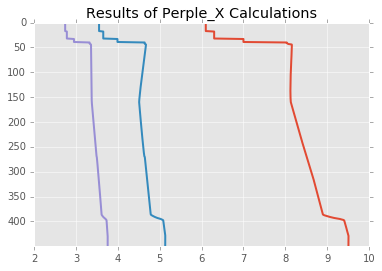

In [ ]:
#Step 3 - Make velocity model and write to card file
from matplotlib import pylab as plt
%matplotlib inline
plt.style.use('ggplot')

from crust1.crust1 import Crust1
c = Crust1().load('crust1/crustal_model_ColoradoPlateau.pickle').print()

ziface1 = abs(c.model.Bottom[5])
ziface2 = abs(c.model.Bottom[6])
zmoho = abs(c.model.Bottom[7])

def extract_profile(fun, crustal_property_column):
    from scipy.interpolate import interp1d
    
    vs, zs = [],[]
    for ii, eachz in enumerate(gt.depths):
        
        val = fun(gt.temps[ii], eachz)
        
        for ilay in [7,6,5]:
            zcritical = abs(c.model.Bottom[ilay])
            if eachz < zcritical:
                val = crustal_property_column[ilay]
            
        vs.append(val)
        zs.append(eachz)

    _ = plt.plot(vs, zs, lw = 2)
    plt.ylim([max(zs),0])
    
    return interp1d(zs,vs)
    
plt.figure(1)
fvp_crst  = extract_profile(fvp, c.model.Vp)
fvs_crst  = extract_profile(fvs, c.model.Vs)
frho_crst = extract_profile(frho, c.model.Density)
_ = plt.title("Results of Perple_X Calculations")

from minos.minos import CardFile

cf = CardFile().read('minos/STW105.txt')
cf0 = CardFile().read('minos/STW105.txt')
cf0=cf0.set_mantle_region(fvp_crst, fvs_crst, frho_crst, zmoho=zmoho)
cf0=cf0.set_crustal_region(c.model)
cf0.write()

plt.figure(2,figsize=(15,5))
_ = plt.plot(cf0.df.Vpv, 6371-cf0.df.Radius/1000, lw = 2, label = 'Vpv (m/s)')
_ = plt.plot(cf0.df.Vph, 6371-cf0.df.Radius/1000, lw = 2, label = 'Vph')
#_ = plt.plot(cf.df.Vpv, 6371-cf.df.Radius/1000, '--k', lw = 0.5)
_ = plt.ylim(500,0)

_ = plt.plot(cf0.df.Vsv, 6371-cf0.df.Radius/1000,label='Vsv', lw=2)
_ = plt.plot(cf0.df.Vsh, 6371-cf0.df.Radius/1000,label='Vsh', lw=2)
#_ = plt.plot(cf.df.Vsv, 6371-cf.df.Radius/1000, '--k', lw = 0.5)

_ = plt.plot(cf0.df.Density, 6371-cf0.df.Radius/1000,label='Density (kg/m$^3$)', lw=2)
#_ = plt.plot(cf.df.Density, 6371-cf.df.Radius/1000, '--k', lw = 0.5)

_ = plt.ylim(500,0)
_ = plt.xlim(2000, 10000)
_ = plt.title("Card File for MINEOS")
_ = plt.ylabel('Depth (km)')
_ = plt.legend()

In [ ]:
#Step 4 - Compute phase velocities

from minos.minos import Minos
Minos().run().plot_output()

In [22]:
!cat default.txt

# radius [m] density [kg/m^3] vpv [m/s] vsv [m/s] Q kappa Q miu vph [m/s] vsh [m/s] eta [m/s] REF
1 1. 1 1
720  180  358  717  739
      0. 13088.48 11262.20  3667.80   1327.6    104.0 11262.20  3667.80  1.00000
   6824. 13088.47 11262.20  3667.79   1327.6    104.0 11262.20  3667.79  1.00000
  13648. 13088.44 11262.18  3667.78   1327.6    104.0 11262.18  3667.78  1.00000
  20472. 13088.39 11262.14  3667.75   1327.6    104.0 11262.14  3667.75  1.00000
  27296. 13088.32 11262.09  3667.72   1327.6    104.0 11262.09  3667.72  1.00000
  34120. 13088.22 11262.02  3667.67   1327.6    104.0 11262.02  3667.67  1.00000
  40944. 13088.11 11261.94  3667.62   1327.6    104.0 11261.94  3667.62  1.00000
  47768. 13087.98 11261.85  3667.55   1327.6    104.0 11261.85  3667.55  1.00000
  54592. 13087.83 11261.74  3667.47   1327.6    104.0 11261.74  3667.47  1.00000
  61416. 13087.66 11261.61  3667.39   1327.6    104.0 11261.61  3667.39  1.00000
  68240. 13087.46 11261.47  3667.29   1327.6    104.0 11261